In [4]:
import torch
import numpy

a = torch.randn(16, 30, 10)
b = torch.randn(16, 30, 10)
a.size()
ab = torch.cat((a,b), dim=0)
ab.size()

torch.Size([32, 30, 10])

In [9]:
from trainer import create_dataset
from metrics import compare_sin3_generation
params = {"max_seq_len": 1000, "alpha": 0.7, "noise": 0.0, "device": "cpu"}

X_hat = create_dataset("sinus", 100, params, device="cpu")[:]
X_hat.size()

dataset: sinus
sin1 freq:[1, 3], phase:[-1.5707963267948966, 0]
sin2 freq:[4, 6], phase:[0, 1.5707963267948966]


torch.Size([100, 1000, 3])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sin1 freq:[1, 1], phase:[-1.5707963267948966, 0.0]
sin2 freq:[4, 4], phase:[0.0, 1.5707963267948966]


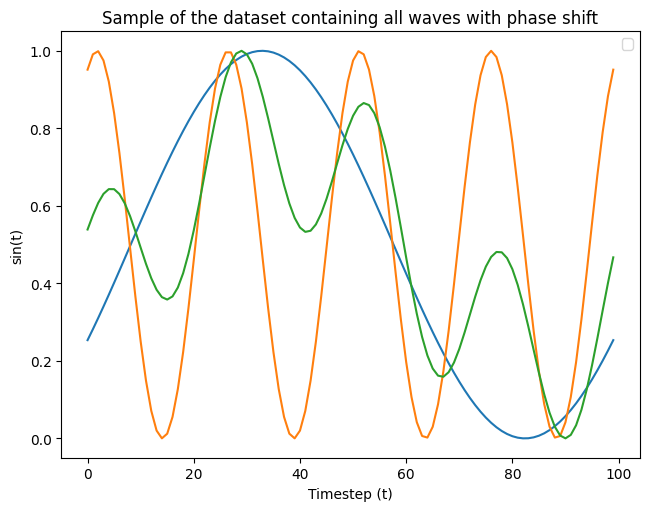

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from utils import DatasetSinus
num = 60
seq_len = 100
alpha= 0.7
noise= 0.0

data = DatasetSinus(num, seq_len,
             alpha, noise,
             s1_freq=[1,1],
             s2_freq=[4,4],
             s1_phase=[-np.pi/2, 0.0],
             s2_phase=[0.0, np.pi/2],
             device="cpu")
#plt.plot(data[0,:,0])
plt.plot(data[0,:])
plt.tight_layout()
plt.ylabel("sin(t)")
plt.xlabel("Timestep (t)")
plt.title("Sample of the dataset containing all waves with phase shift")
plt.legend()
#plt.plot(data[0,:,1])

#### What exactly an LSTM returns and shapes the data

In [12]:
input_tensor = torch.tensor([[[1., 1., 1.],
                              [2., 2., 2.],
                              [3., 3., 3.]]])
input_size = input_tensor.size(-1)
hidden_size = 3
lstm = torch.nn.LSTM(input_size=input_size,
                     hidden_size=hidden_size,
                     num_layers=1,
                     batch_first=True)
output, (h_n, c_n) = lstm(input_tensor)
output, (h_n, c_n)

class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, batch_first=True):
        super(LSTM, self).__init__()
        self.lstm = torch.nn.LSTM(input_size=input_size,
                                  hidden_size=hidden_size,
                                  num_layers=num_layers,
                                  batch_first=batch_first)

    def forward(self, x):
        output, (h_n, c_n) = self.lstm(x)
        return output, (h_n, c_n)
LSTM(input_size, hidden_size)

<generator object Module.parameters at 0x14135f430>

In [3]:
print(f"output size: {output.size()}, (batch_size, seq_len, H_out)")
print(f"h_n size:    {h_n.size()}, (batch_size, num_layers, H_out)")
print(f"c_n size:    {c_n.size()}, (num_layers, batch_size, H_cell)")

output size: torch.Size([1, 3, 3]), (batch_size, seq_len, H_out)
h_n size:    torch.Size([1, 1, 3]), (batch_size, num_layers, H_out)
c_n size:    torch.Size([1, 1, 3]), (num_layers, batch_size, H_cell)


In [ ]:
input_tensor = torch.tensor([[[1., 1., 1.],
                              [2., 2., 2.],
                              [3., 3., 3.],
                              [4., 4., 4.]]])

In [ ]:
x = input_tensor
x = x.permute(0, 2, 1)
x

## Setting generator seeds

In [1]:
%load_ext autoreload
%autoreload

from architectures import COTGAN
from utils import DatasetSinus, log_visualizations
from trainer import cotgan_trainer, cotgan_generator
from metrics import *
import numpy as np
import torch
import matplotlib.pyplot as plt

seed = 42
alpha = 0.7
noise = 0
np.random.seed(seed)
torch.manual_seed(seed)

device = "cpu"
trainset = DatasetSinus(num=6*12, seq_len=25, alpha=alpha, noise=noise, device=device)

sin1 freq:[1, 3], phase:[-1.5707963267948966, 0]
sin2 freq:[4, 6], phase:[0, 1.5707963267948966]


In [ ]:
trainset[:6][0].shape

In [ ]:
params = {
    "model_name": "model_cotgan.pt",
    "n_epochs": 1,
    "l_rate": 0.001, # for both D and G
    "batch_size": 32,
    "dis_rnn_num_layers": 1,
    #"dis_rnn_hidden_dim": 20,
    "gen_rnn_num_layers": 2,
    "gen_rnn_hidden_dim": 5,
    "hidden_dim": 10, # generator: hidden dim in FC, discriminator: filters in Convolution
    "num_hidden_layers": 2, # generator fully-connected layers

    "scaling_coef": 1.0, # distance scaling (TODO(Not implemented))
    "sinkhorn_eps": 0.8, # epsilon regularizer
    "sinkhorn_l":   100, # sinkhorn calculation iterations
    "reg_lam":      10.0, # martingale penalty coefficient

    "Z_dim": 20,
    "optimizer": "Adam", # RMSprop, Adam
    "beta1": 0.5,
    "beta2": 0.9,
    "dataset": "sines",
    "feature_dim": trainset[0][0].size(1),
    "max_seq_len": trainset[0][0].size(0),
    "trainset_size": len(trainset),
    "device": device,
}

model = COTGAN(params)

In [ ]:
z1 = torch.randn(6,params["max_seq_len"], params["Z_dim"])
z2 = torch.randn(6,params["max_seq_len"], params["Z_dim"])

x1 = trainset[:6][0]
x2 = trainset[6:12][0]

In [ ]:
model(z1,z2,x1,x2, obj="discriminator")

In [ ]:
x1.size()

In [ ]:
import torch
batch_size = 6
seq_len = 25
dim_size = 3
x = torch.randn(batch_size, seq_len, dim_size)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# def create_sin_wave but writte with torch
def create_sin_wave(spatial_len=25, seq_len=10):
    e = torch.rand(1) * 0.6
    x = torch.linspace(0, 1, spatial_len) + e
    time = torch.linspace(0, 0.3, seq_len)
    amplitude = 0.5
    freq = 1.5
    y = amplitude * torch.sin( 2 * np.pi * freq * (x + time[:, None])) + 0.5
    #plt.plot(y.T[:,:]);
    return y
create_sin_wave(spatial_len=50, seq_len=25);

In [ ]:
batch_size = 32
hidden_dim = 10
rnn_hidden_dim = 15
max_seq_len = 25
spatial_len = 50
data = torch.stack([create_sin_wave(spatial_len=spatial_len, seq_len=max_seq_len) for _ in range(batch_size)])
data.size()

In [ ]:
# DISCRIMINATOR
disc = torch.nn.Sequential(torch.nn.Conv1d(in_channels=1, out_channels=hidden_dim, kernel_size=5, stride=1, padding=2),
                           torch.nn.BatchNorm1d(hidden_dim),
                           torch.nn.ReLU(),
                           torch.nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim*2, kernel_size=5, stride=1, padding=2),
                           torch.nn.BatchNorm1d(hidden_dim*2),
                           torch.nn.ReLU(),
                           )

rnn = torch.nn.GRU(input_size=hidden_dim * 2 * spatial_len, hidden_size=rnn_hidden_dim, num_layers=1, batch_first=True)

In [ ]:
# forward pass
batch_size = 32
max_seq_len = 25
spatial_len = 50
data = torch.rand(batch_size, max_seq_len, spatial_len)
print(f"input size: \t\t{data.size()}")
x = data.view(batch_size*max_seq_len, 1, -1)
print(f"input size: \t\t{x.size()}")
x = disc(x)
print(f"disc output size:   {x.size()}")
x = x.view(batch_size, max_seq_len, -1)
print(f"rnn input size: \t{x.size()}")
x, _ = rnn(x)
print(f"rnn output size: \t{x.size()}")



In [ ]:
max_seq_len = 25
x = torch.randn(batch_size, max_seq_len , spatial_len)
hidden_dim = 20
m1 = torch.nn.Conv1d(in_channels=1, out_channels=hidden_dim, kernel_size=5, stride=1, padding=2)
m2 = torch.nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim*2, kernel_size=5, stride=1, padding=2)
x = x.view(batch_size*max_seq_len, 1, -1)
x = m1(x)
x = m2(x)
#x.size()
print(x.size())
x = x.view(batch_size, max_seq_len, -1)
print(x.size())
2000 == 20 * 50 * 2

In [ ]:
# GENEARATOR
batch_size = 16
Z_dim = 10
gen_rnn_hidden_dim = 25
gen_rnn = torch.nn.GRU(input_size=Z_dim,
                        hidden_size=gen_rnn_hidden_dim,
                        num_layers=1,
                        batch_first=True)
gen_rnn2 = torch.nn.GRU(input_size=gen_rnn_hidden_dim,
                        hidden_size=gen_rnn_hidden_dim * 2,
                        num_layers=1,
                        batch_first=True)
linear = torch.nn.Linear(in_features=gen_rnn_hidden_dim * 2, out_features=1)

In [ ]:
x = torch.randn(batch_size, max_seq_len, Z_dim)
print(f"input size: \t\t\t{x.size()}")
x, _ = gen_rnn(x)
print(f"gen_rnn output size: \t{x.size()}")
x, _ = gen_rnn2(x)
print(f"gen_rnn2 output size: \t{x.size()}")
x = linear(x)
print(f"linear output size: \t{x.size()}")


In [ ]:
def grid(P=20, M=100):
    dx = P/M
    x = np.linspace(0, P-dx, M)
    return x, dx

In [50]:
c = 2 # the speed, and two times the height of the wave
P = 20 # period
M = 100 # number of spatial points

t_range = (0, 6)

x, dx = grid(P, M)
x += P/4 # start the wave at x=5
sech = lambda a: 1/np.cosh(a) # sech isn't defined in NumPy
c_t = lambda t: c + 0.02*(t-t_range[0])*(t-t_range[1]) # t^2 term in the equation
u_soliton = lambda x, t: 1/2*c_t(t)*sech(np.abs((x-c*t) % P - P/2))**2

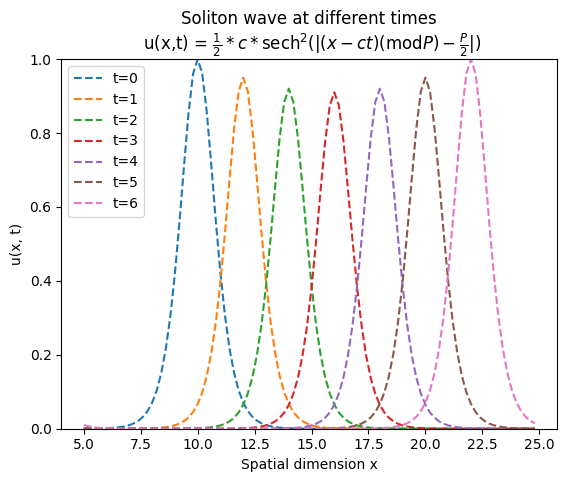

In [51]:
plt.plot(x, u_soliton(x, 0), '--', label="t=0")
plt.plot(x, u_soliton(x, 1), '--', label="t=1")
plt.plot(x, u_soliton(x, 2), '--', label="t=2")
plt.plot(x, u_soliton(x, 3), '--', label="t=3")
plt.plot(x, u_soliton(x, 4), '--', label="t=4")
plt.plot(x, u_soliton(x, 5), '--', label="t=5")
plt.plot(x, u_soliton(x, 6), '--', label="t=6")
plt.ylim(0, 1)
u_t_x = r"u(x,t) = $\frac{1}{2} *c* \mathrm{sech}^2 (| (x - c t) (\mathrm{mod}P)-\frac{P}{2}|)$"
plt.title(f"Soliton wave at different times\n {u_t_x}")
plt.xlabel("Spatial dimension x")
plt.ylabel("u(x, t)")
plt.legend()

In [44]:
# create a dataset of soliton waves

class DatasetSoliton(torch.utils.data.Dataset):
    def __init__(self, n_samples, P, t_range, c_range, spatial_len=50, t_steps=25, device="cpu", difficulty="easy"):
        self.t_range = t_range # [0, 6]
        self.c_range = c_range # [0.5, 2]
        self.P = P # period
        self.n_samples = n_samples
        self.t_steps = t_steps
        self.spatial_len = spatial_len # M
        self.difficulty = difficulty # "easy" or "medium"
        self.data = self.create_soliton_dataset_torch()
        self.data = self.data.to(device)


    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.data[idx]

    def get_params(self):
        # return the parameters of the dataset with lists as string
        return {"t_range": self.t_range, "c_range": self.c_range, "P": self.P,
                "t_steps": self.t_steps, "spatial_len": self.spatial_len}
    def create_soliton_dataset_torch(self):
        sech = lambda a: 1/torch.cosh(a) # sech isn't defined in NumPy
        c_t = None
        # specify the height of the wave as a function of time for a harder dataset
        if self.difficulty == "easy":
            c_t = lambda t: 0
        elif self.difficulty == "medium":
            c_t = lambda t: 0.025*(t-t_range[0])*(t-t_range[1]) # height of the wave as a function of time
        else:
            raise ValueError("difficulty must be 'easy' or 'medium'")

        u_soliton_t = lambda x, t, c, P: 1/2*(c + c_t(t))*sech(torch.abs((x-c*t) % P - P/2))**2

        def grid(P, M):
            dx = P/M
            x = torch.linspace(0, P-dx, M)
            return x, dx

        data = torch.zeros((self.n_samples, self.t_steps, self.spatial_len))
        # random speed =c
        # Uniformly distributed values between c_range[0] and c_range[1]
        c_arr = torch.rand(self.n_samples) * (self.c_range[1] - self.c_range[0]) + self.c_range[0]
        t = torch.linspace(self.t_range[0], self.t_range[1], self.t_steps)
        x, dx = grid(self.P, self.spatial_len)
        x += self.P/4 # start the wave at x=5
        for i in range(self.n_samples):
            c = c_arr[i]
            u = u_soliton_t(x, t[:, None], c, self.P)
            data[i] = u
        return data


In [45]:
# Global parameters [min, max]
c_range = [0.5, 2] # torch.uniform(0.5, 2)
t_range = [0, 6] # torch.linspace(0, 3, t_steps)
t_steps = 25
P = 20
M = 100
dataset = DatasetSoliton(n_samples=100, P=P, t_range=t_range, c_range=c_range, spatial_len=M, t_steps=t_steps, device="cpu", difficulty="medium")

In [46]:
dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=16,
        shuffle=True
    )

torch.Size([16, 25, 100])


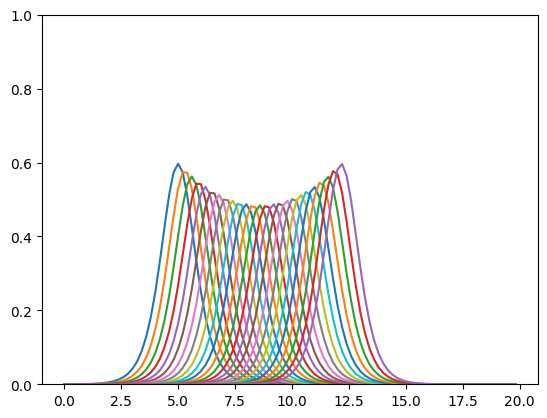

In [47]:

def grid(P=20, M=100):
    dx = P/M
    x = np.linspace(0, P-dx, M)
    return x, dx
x, dx = grid(P, M)


for X_mb in dataloader:
    print(X_mb.size())
    plt.plot(x, X_mb[0].T)
    plt.ylim(0, 1)
    break

## Generator with GRU and Conv1dTranspose
- Not sure if this works yet

In [ ]:

import torch
import torch.nn as nn
batch_size = 16
max_seq_len = 25
Z_dim = 10

gen_rnn_hidden_dim = 64
gen_rnn_num_layers = 1

# real data shapes
P = 10
spatial_len = 50
t_steps = 25

gen_rnn = nn.GRU(input_size=Z_dim,
                hidden_size=gen_rnn_hidden_dim,
                num_layers=1,
                batch_first=True)
# For FC layers
input_hidden = gen_rnn_hidden_dim
if gen_rnn_num_layers > 1:
    input_hidden = gen_rnn_hidden_dim * 2
    gen_rnn2 = nn.GRU(input_size=gen_rnn_hidden_dim,
                    hidden_size=gen_rnn_hidden_dim * 2,
                    num_layers=1,
                    batch_first=True)

gen_conv = nn.ConvTranspose1d(in_channels=1,
                            out_channels=5,
                            kernel_size=3,
                            stride=1,
                            padding=1,
                            bias=True,
                            )

# define data and forward pass
data = torch.rand(batch_size, max_seq_len, Z_dim)
x, _ = gen_rnn(data)
print(x.size())
x = data.view(batch_size * max_seq_len, 1, -1)
x = gen_conv(x)
x.view(batch_size, max_seq_len, -1).size()

## PCA and UMAP on Soliton data

In [ ]:
from trainer import create_dataset
from utils import visualization, DatasetSoliton
P = 20
M = 100
t_steps = 50
n_samples = 1000
real_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 2], spatial_len=M, t_steps=t_steps)[:n_samples]
fake_data = DatasetSoliton(n_samples, P=P, t_range=[0, 5], c_range=[0.5, 1.9], spatial_len=M, t_steps=t_steps)[:n_samples]

visualization(real_data, fake_data, 'pca');

In [ ]:
plt.plot(real_data[7,12])

In [ ]:
%%time
# Get height of the first wave
c_values1 = real_data[:, 0,:].max(dim=1)[0]
c_values2 = fake_data[:, 0,:].max(dim=1)[0]


def two_sample_kolmogorov_smirnov(x, y):
    from scipy.stats import ks_2samp
    """Two sample Kolmogorov-Smirnov test which calculates if the samples are being drawn from the same distribution,
         p-value less than 0.05 means that the samples are not from the same distribution.
    Args:
        x (torch.Tensor): (n_samples, )
        y (torch.Tensor): (n_samples, )
    :returns: p-value
    """
    return ks_2samp(x, y)[1]

prob = two_sample_kolmogorov_smirnov(c_values1, c_values2)
prob

In [ ]:
fig = plt.figure(figsize=(7, 5))
plt.hist(2*c_values1, bins=100, density=True, alpha=0.8)
plt.xlim(0.5, 2)

In [ ]:
import torch
import matplotlib.pyplot as plt
device = "mps"
u = torch.rand(1000)
c_range = torch.tensor([0.5, 2])
c = torch.rand(1000) * (c_range[1] - c_range[0]) + c_range[0]
plt.hist(c, bins=100);

In [ ]:
real_data[:1, :, :].max(dim=2)[0].shape, c_values1[0]

In [ ]:
def mae_height_diff(data):
    """Mean absolute error between the max height of the first wave and all other preceding waves
    Args:
        data (torch.Tensor): (n_samples, t_steps, spatial_len)
    """
    if type(data) != torch.Tensor:
        raise TypeError('Data must be a torch.Tensor')
    return (data.max(dim=2)[0] - data[:, 0, :, None].max(dim=1)[0]).abs().mean()

(real_data[:, :, :].max(dim=2)[0] - c_values1[:, None]).abs().mean()

In [ ]:
mae_height_diff(real_data)

## Approximated Sinkhorn distance investigation
Reshaping the data to be (n_samples * t_steps, spatial_len) seemed to be most stable

In [69]:
from metrics import sw_approx, sinkhorn_distance
from utils import visualization, DatasetSoliton
plt.figure(figsize=(7, 5), dpi=300)
P = 20
M = 100
t_steps = 50
n_samples = 1000
real_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 2], spatial_len=M, t_steps=t_steps)[:n_samples]
fake_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 1], spatial_len=M, t_steps=t_steps)[:n_samples]


<Figure size 2100x1500 with 0 Axes>

In [0]:
%%time
#real_data = torch.randn(5000, 3)
#fake_data = torch.randn(5000, 3)
#sw_approx(real_data, fake_data), \
n = 100
b_t_m = torch.zeros(n)
bt_m = torch.zeros(n)
b_tm = torch.zeros(n)

for i in range(n):
    real_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 2], spatial_len=M, t_steps=t_steps)[:n_samples]
    fake_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 2], spatial_len=M, t_steps=t_steps)[:n_samples]
    b_t_m[i] = sw_approx(real_data, fake_data)
    bt_m[i] = sw_approx(real_data.view(n_samples*t_steps, -1 ), fake_data.view(n_samples*t_steps, -1 ))
    b_tm[i] = sw_approx(real_data.view(-1, t_steps* M ), fake_data.view(-1, t_steps* M ))
bt_m_0 = bt_m

(N,S,D) mean, std: 0.0032757921144366264, 0.0026996901724487543
(NS,D)  mean, std: 0.00014301174087449908, 0.0001434671867173165
(N,SD)  mean, std: 0.0031892412807792425, 0.0026539459358900785


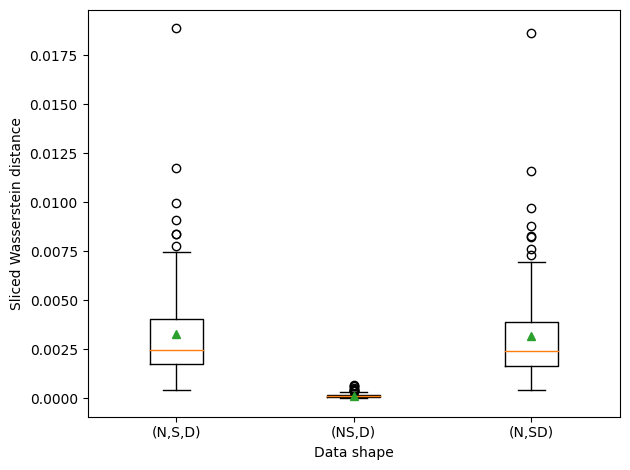

In [85]:

#print(f"b_t_m: {b_t_m.mean()}, bt_m: {bt_m.mean()}, b_tm: {b_tm.mean()}")
print(f"(N,S,D) mean, std: {b_t_m.mean()}, {b_t_m.std()}")
print(f"(NS,D)  mean, std: {bt_m.mean()}, {bt_m.std()}")
print(f"(N,SD)  mean, std: {b_tm.mean()}, {b_tm.std()}")
plt.boxplot([b_t_m, bt_m, b_tm], labels=['(N,S,D)', '(NS,D)', '(N,SD)'], showmeans=True, vert=True);
plt.ylabel('Sliced Wasserstein distance')

plt.xlabel('Data shape')
plt.tight_layout()
plt.savefig('sw_approx.png', dpi=300)

b_t_m: 0.10083921253681183, bt_m: 0.003221268067136407, b_tm: 0.10015129297971725
CPU times: user 15.8 s, sys: 3.54 s, total: 19.3 s
Wall time: 12.1 s


{'whiskers': [<matplotlib.lines.Line2D at 0x294b4ec10>,
 'caps': [<matplotlib.lines.Line2D at 0x294b5e190>,
 'boxes': [<matplotlib.lines.Line2D at 0x294b4e970>,
 'medians': [<matplotlib.lines.Line2D at 0x294b5e6d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x294b5e970>,
 'means': []}

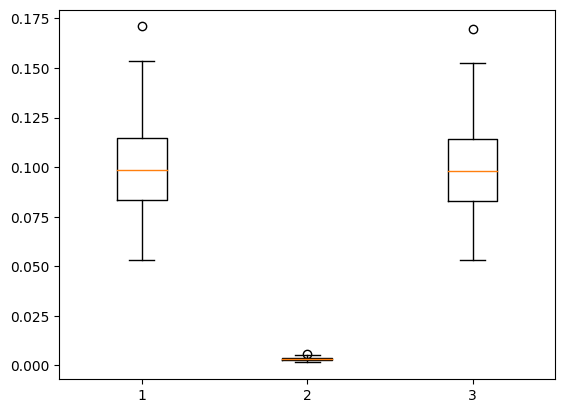

In [54]:
%%time
#real_data = torch.randn(5000, 3)
#fake_data = torch.randn(5000, 3)
#sw_approx(real_data, fake_data), \
n = 100
b_t_m = torch.zeros(n)
bt_m = torch.zeros(n)
b_tm = torch.zeros(n)

for i in range(n):
    real_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 2], spatial_len=M, t_steps=t_steps)[:n_samples]
    fake_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 1.9], spatial_len=M, t_steps=t_steps)[:n_samples]
    b_t_m[i] = sw_approx(real_data, fake_data)
    bt_m[i] = sw_approx(real_data.view(n_samples*t_steps, -1 ), fake_data.view(n_samples*t_steps, -1 ))
    b_tm[i] = sw_approx(real_data.view(-1, t_steps* M ), fake_data.view(-1, t_steps* M ))
bt_m_1 = bt_m
print(f"b_t_m: {b_t_m.mean()}, bt_m: {bt_m.mean()}, b_tm: {b_tm.mean()}")
plt.boxplot([b_t_m, bt_m, b_tm]);

b_t_m: 0.349715918302536, bt_m: 0.011965560726821423, b_tm: 0.34722796082496643
CPU times: user 15.8 s, sys: 3.36 s, total: 19.1 s
Wall time: 12.2 s


{'whiskers': [<matplotlib.lines.Line2D at 0x294be7fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x294bf7550>,
 'boxes': [<matplotlib.lines.Line2D at 0x294be7d30>,
 'medians': [<matplotlib.lines.Line2D at 0x294bf7a90>,
 'fliers': [<matplotlib.lines.Line2D at 0x294bf7d30>,
 'means': []}

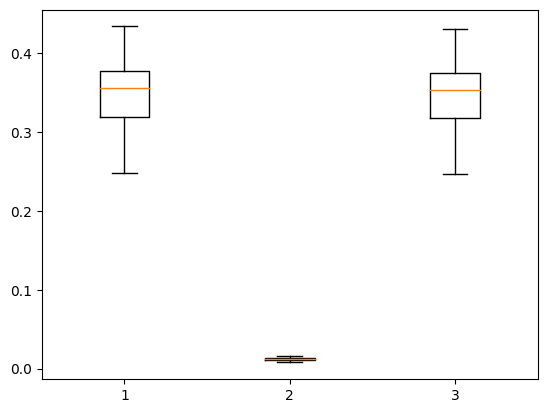

In [55]:
%%time
#real_data = torch.randn(5000, 3)
#fake_data = torch.randn(5000, 3)
#sw_approx(real_data, fake_data), \
n = 100
b_t_m = torch.zeros(n)
bt_m = torch.zeros(n)
b_tm = torch.zeros(n)

for i in range(n):
    real_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 2], spatial_len=M, t_steps=t_steps)[:n_samples]
    fake_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 1.8], spatial_len=M, t_steps=t_steps)[:n_samples]
    b_t_m[i] = sw_approx(real_data, fake_data)
    bt_m[i] = sw_approx(real_data.view(n_samples*t_steps, -1 ), fake_data.view(n_samples*t_steps, -1 ))
    b_tm[i] = sw_approx(real_data.view(-1, t_steps* M ), fake_data.view(-1, t_steps* M ))
bt_m_2 = bt_m
print(f"b_t_m: {b_t_m.mean()}, bt_m: {bt_m.mean()}, b_tm: {b_tm.mean()}")
plt.boxplot([b_t_m, bt_m, b_tm]);

b_t_m: 0.9437771439552307, bt_m: 0.040423255413770676, b_tm: 0.9356281161308289
CPU times: user 15.8 s, sys: 3.33 s, total: 19.1 s
Wall time: 12.2 s


{'whiskers': [<matplotlib.lines.Line2D at 0x294c7f640>,
 'caps': [<matplotlib.lines.Line2D at 0x294c7fb80>,
 'boxes': [<matplotlib.lines.Line2D at 0x294c7f3a0>,
 'medians': [<matplotlib.lines.Line2D at 0x294c7ffa0>,
 'fliers': [<matplotlib.lines.Line2D at 0x294c8f280>,
 'means': []}

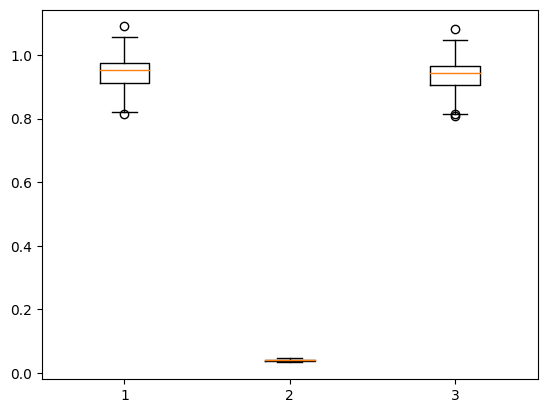

In [56]:
%%time
#real_data = torch.randn(5000, 3)
#fake_data = torch.randn(5000, 3)
#sw_approx(real_data, fake_data), \
n = 100
b_t_m = torch.zeros(n)
bt_m = torch.zeros(n)
b_tm = torch.zeros(n)

for i in range(n):
    real_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 2], spatial_len=M, t_steps=t_steps)[:n_samples]
    fake_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 1.6], spatial_len=M, t_steps=t_steps)[:n_samples]
    b_t_m[i] = sw_approx(real_data, fake_data)
    bt_m[i] = sw_approx(real_data.view(n_samples*t_steps, -1 ), fake_data.view(n_samples*t_steps, -1 ))
    b_tm[i] = sw_approx(real_data.view(-1, t_steps* M ), fake_data.view(-1, t_steps* M ))
bt_m_3 = bt_m
print(f"b_t_m: {b_t_m.mean()}, bt_m: {bt_m.mean()}, b_tm: {b_tm.mean()}")
plt.boxplot([b_t_m, bt_m, b_tm]);

b_t_m: 1.8958288431167603, bt_m: 0.1495179682970047, b_tm: 1.8703720569610596
CPU times: user 15.8 s, sys: 3.37 s, total: 19.2 s
Wall time: 12.2 s


{'whiskers': [<matplotlib.lines.Line2D at 0x294d17610>,
 'caps': [<matplotlib.lines.Line2D at 0x294d17b50>,
 'boxes': [<matplotlib.lines.Line2D at 0x294d17370>,
 'medians': [<matplotlib.lines.Line2D at 0x294d250d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x294d25370>,
 'means': []}

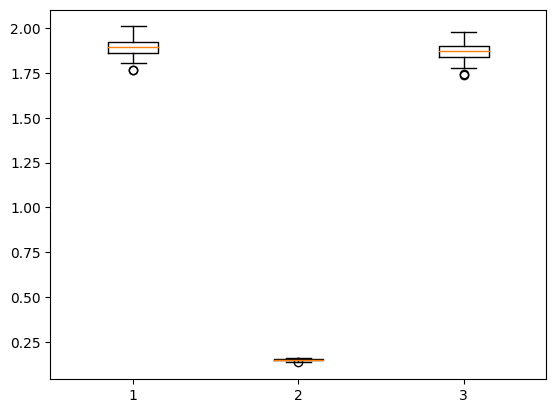

In [57]:
%%time
#real_data = torch.randn(5000, 3)
#fake_data = torch.randn(5000, 3)
#sw_approx(real_data, fake_data), \
n = 100
b_t_m = torch.zeros(n)
bt_m = torch.zeros(n)
b_tm = torch.zeros(n)

for i in range(n):
    real_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 2], spatial_len=M, t_steps=t_steps)[:n_samples]
    fake_data = DatasetSoliton(n_samples, P=P, t_range=[0, 6], c_range=[0.5, 1], spatial_len=M, t_steps=t_steps)[:n_samples]
    b_t_m[i] = sw_approx(real_data, fake_data)
    bt_m[i] = sw_approx(real_data.view(n_samples*t_steps, -1 ), fake_data.view(n_samples*t_steps, -1 ))
    b_tm[i] = sw_approx(real_data.view(-1, t_steps* M ), fake_data.view(-1, t_steps* M ))
bt_m_4 = bt_m
print(f"b_t_m: {b_t_m.mean()}, bt_m: {bt_m.mean()}, b_tm: {b_tm.mean()}")
plt.boxplot([b_t_m, bt_m, b_tm]);

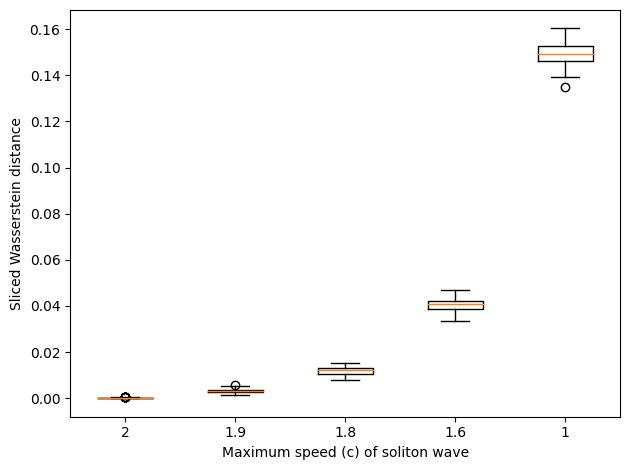

In [84]:


plt.boxplot([bt_m_0, bt_m_1, bt_m_2, bt_m_3, bt_m_4], labels=["2", "1.9", "1.8", "1.6", "1"]);
#plt.boxplot([b_t_m, bt_m, b_tm], labels=['(N,S,D)', '(NS,D)', '(N,SD)'], showmeans=True, vert=True);
plt.ylabel('Sliced Wasserstein distance')
plt.xlabel('Maximum speed (c) of soliton wave')
plt.tight_layout()
plt.savefig('sw_speed.png', dpi=300)


In [59]:
torch.stack([bt_m_0, bt_m_1, bt_m_2, bt_m_3, bt_m_4]).mean(dim=1)

tensor([1.3266e-04, 3.2213e-03, 1.1966e-02, 4.0423e-02, 1.4952e-01])

# Testing to load soliton dataset

In [23]:
import numpy as np
file_dir = ""
file_names = ["0_eta=6p0_gamma=1p0_tmax=10_P=50_N=360_M=360_lower=0p2_upper=0p7.npy",
              "1_eta=6p0_gamma=1p0_tmax=10_P=50_N=360_M=360_lower=0p2_upper=0p7.npy",
              "2_eta=6p0_gamma=1p0_tmax=10_P=50_N=360_M=360_lower=0p2_upper=0p7.npy"]
#file_name = file_names[0]

data_arr = []
dx = 180
dt = 180

for file_name in file_names:
    data_high_res = np.load(file_dir + file_name)
    N_samples, N, M = data_high_res.shape
    dx_step = M // dx
    dt_step = N // dt
    print(f"RAW data: {data_high_res.shape}, MB: {data_high_res.nbytes / 1e6}")
    data_low_res = data_high_res[:, ::dt_step, ::dx_step]
    del data_high_res
    print(f"\tDownsampled:{data_low_res.shape}, MB: {data_low_res.nbytes / 1e6}")
    data_arr.append(data_low_res)

data = np.concatenate(data_arr, axis=0)
print(f"Concatenated data with shape {data.shape} and size: {data.nbytes / 1e6} MB")

RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 180, 180), MB: 129.6
RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 180, 180), MB: 129.6
RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 180, 180), MB: 129.6
Concatenated data with shape (3000, 180, 180) and size: 388.8 MB


In [25]:
from create_dataset import DatasetTwoCollidingSolitons
dataset = DatasetTwoCollidingSolitons(file_dir="", dx=60, dt=60)

RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 60, 60), MB: 14.4
RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 60, 60), MB: 14.4
RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 60, 60), MB: 14.4
Concatenated data with shape (3000, 60, 60) and size: 43.2 MB


In [26]:
dataset[0].shape

(60, 60)

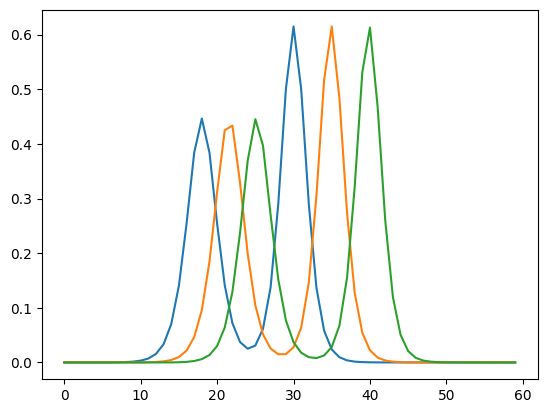

In [35]:
import matplotlib.pyplot as plt
plt.plot(dataset[3][::20, :].T);


# Hamiltonian dx test

In [1]:
%load_ext autoreload

dataset: twosolitons
Loading dataset: Two Solitons
RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 30, 120), MB: 14.4
RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 30, 120), MB: 14.4
RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 30, 120), MB: 14.4
Concatenated data with shape (3000, 30, 120) and size: 43.2 MB


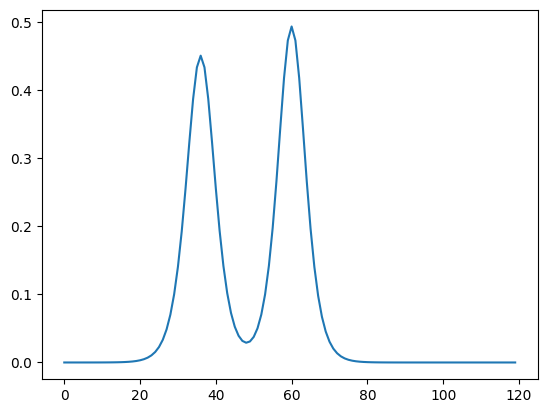

In [26]:
%autoreload
import matplotlib.pyplot as plt
from trainer import create_dataset
import matplotlib.pyplot as plt

p = {"dx": 120, "dt": 30, "device": "cpu"}
dataset = create_dataset("twosolitons", 10, p, device="cpu")
dataset[:1].size()
plt.plot(dataset[0, 0, :].T);

torch.Size([1, 30])


tensor([[0.0000, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0007,
         0.0008, 0.0008, 0.0009, 0.0009, 0.0010, 0.0011, 0.0011, 0.0012, 0.0012,
         0.0012, 0.0012, 0.0013, 0.0013, 0.0014, 0.0014, 0.0014, 0.0015, 0.0015,
         0.0015, 0.0016, 0.0016]])

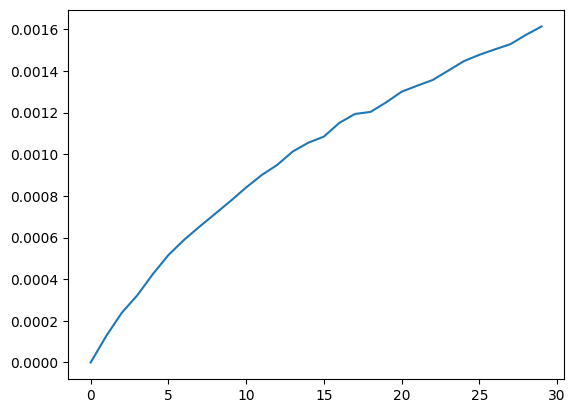

In [66]:

from metrics import mass_conservation, momentum_conservation, energy_conservation
import torch

H_mass = energy_conservation(dataset[:1], dx=1, eta=6.0, gamma=1.0)
print(H_mass.shape)
plt.plot(H_mass[0, :]);
H_mass

In [64]:
# Conv1d testing
import torch.nn as nn
b = 1
input = torch.randn(b, 100, 16)
input = input.view(b*100, 1, -1)
m = nn.Conv1d(in_channels=1, out_channels=25, kernel_size=3, stride=1, padding="same")

output = m(input)
output.size(), output.view(b, 100, -1).size()

(torch.Size([100, 25, 16]), torch.Size([1, 100, 400]))

In [50]:
m

Conv1d(3, 25, kernel_size=(5,), stride=(1,))

In [53]:
input = torch.randn(1, 100, 16)
input = input.permute(0, 2, 1)
m = nn.Conv1d(in_channels=16, out_channels=25, kernel_size=5, stride=1)

output = m(input)
output.size()

torch.Size([1, 25, 96])

In [9]:
import torch
torch.manual_seed(1) # pytorch


In [10]:
torch.initial_seed() % 2**32

1

# PLOTTING SOLITON DATA

In [556]:
# The same but for whole plots instead of points

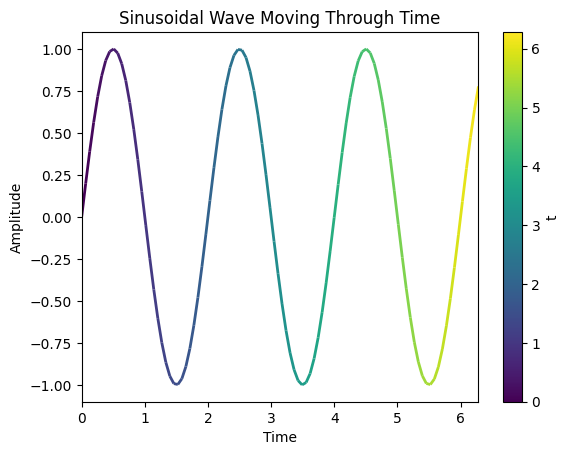

In [557]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.collections import LineCollection

# Define the time range and the frequency of the wave
t = np.linspace(0, 2*np.pi, 100)
f = 0.5

# Calculate the sine wave
wave = np.sin(2 * np.pi * f * t)

# Set up the color gradient using two nice colors
colors = cm.get_cmap('coolwarm', len(t))

# Create a list of line segments for LineCollection
lines = []
for i in range(len(t)-1):
    lines.append([(t[i], wave[i]), (t[i+1], wave[i+1])])

segments = [np.column_stack([t[i:i+2], wave[i:i+2]]) for i in range(len(t) - 1)]
# Create LineCollection with color gradient
fig, ax = plt.subplots()
ax.axis([0,2*np.pi,-1.1,1.1]) #set axis limits. This is [xlow, xhigh, ylow, yhigh]

lc = LineCollection(segments, cmap='viridis',array=t,linewidth=2)
line = ax.add_collection(lc)
plt.colorbar(line, label='t')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sinusoidal Wave Moving Through Time')

# Show the plot
plt.show()

## Plots for solitos

In [575]:
# Two Colliding Solitons
from create_dataset import DatasetTwoCollidingSolitons
data = DatasetTwoCollidingSolitons(file_dir="datasets/", dx=120, dt=30)

RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 30, 120), MB: 14.4
RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 30, 120), MB: 14.4
RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 30, 120), MB: 14.4
Concatenated data with shape (3000, 30, 120) and size: 43.2 MB


In [3]:
# Single Soliton
from utils import DatasetSoliton
data = DatasetSoliton(1000, P=50, t_range=[0,10], c_range=[0.5, 2], spatial_len=120, t_steps=30)


In [617]:
sample = data[6]

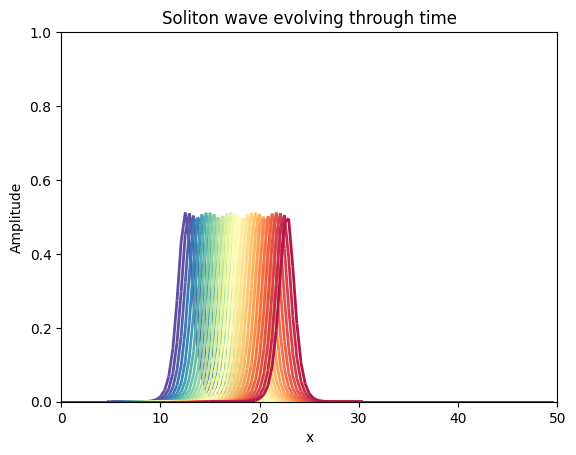

In [618]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

time_steps, x_dim = sample.shape
# Define the time range and the frequencies of the waves
t = np.linspace(0, 50-50/x_dim, x_dim)

# Create LineCollection for each wave with a single color
lines = []
colors = cm.get_cmap('Spectral', time_steps)
for i, wave in enumerate(sample):
    segments = [np.column_stack([t[i:i+2], wave[i:i+2]]) for i in range(len(t) - 1)]

    lc = LineCollection(segments, colors=colors(time_steps -i), linewidth=2)
    lines.append(lc)

# Plot all LineCollections on the same axes
fig, ax = plt.subplots()
ax.axis([0,50,0,1]) #set axis limits. This is [xlow, xhigh, ylow, yhigh]

lin = []
for lc in lines:
    line = ax.add_collection(lc)
    lin.append(line)
# Add labels and title
plt.xlabel('x')
plt.ylabel('Amplitude')
plt.title('Soliton wave evolving through time')
# Show the plot
plt.show()


/var/folders/wb/p5xwlpld3rbb00y719123mvr0000gn/T/ipykernel_3892/190211048.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


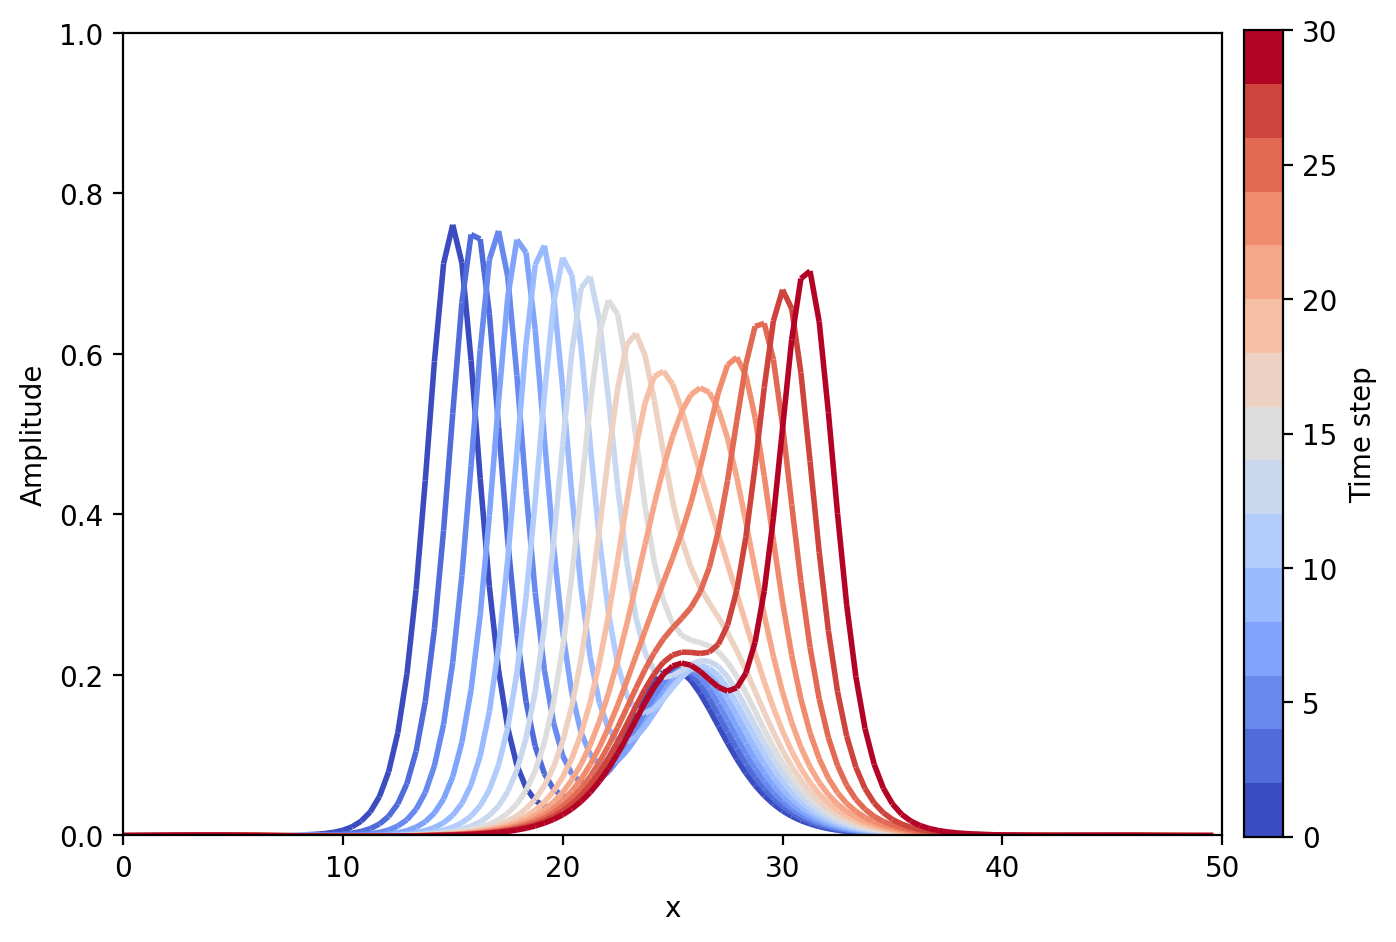

In [578]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
def plot_sample_oneplot(sample, dt_step=1):

    time_steps, x_dim = sample.shape
    # Define the time range and the frequencies of the waves
    x = np.linspace(0, 50-50/x_dim, x_dim)
    sample = sample[::dt_step]
    # Create LineCollection for each wave with a single color
    lines = []
    colors = cm.get_cmap('coolwarm', sample.shape[0])
    for i, wave in enumerate(sample):
        segments = [np.column_stack([x[i:i+2], wave[i:i+2]]) for i in range(len(x) - 1)]

        lc = LineCollection(segments, colors=colors(i), linewidth=2)
        lines.append(lc)

    # Plot all LineCollections on the same axes
    fig, ax = plt.subplots( dpi=200)
    ax.axis([0,50,0,1]) #set axis limits. This is [xlow, xhigh, ylow, yhigh]

    for lc in lines:
        line = ax.add_collection(lc)

    # Add labels and title
    plt.xlabel('x')
    plt.ylabel('Amplitude')
    # colorbar
    sm = plt.cm.ScalarMappable(cmap=colors, norm=plt.Normalize(vmin=0, vmax=time_steps))
    sm.set_array([])
    plt.colorbar(sm, label='Time step', cax=fig.add_axes([0.98, 0.12, 0.03, 0.84]))
    plt.tight_layout()
    # Show the plot
    plt.show()
plot_sample_oneplot(data[17],dt_step=2)

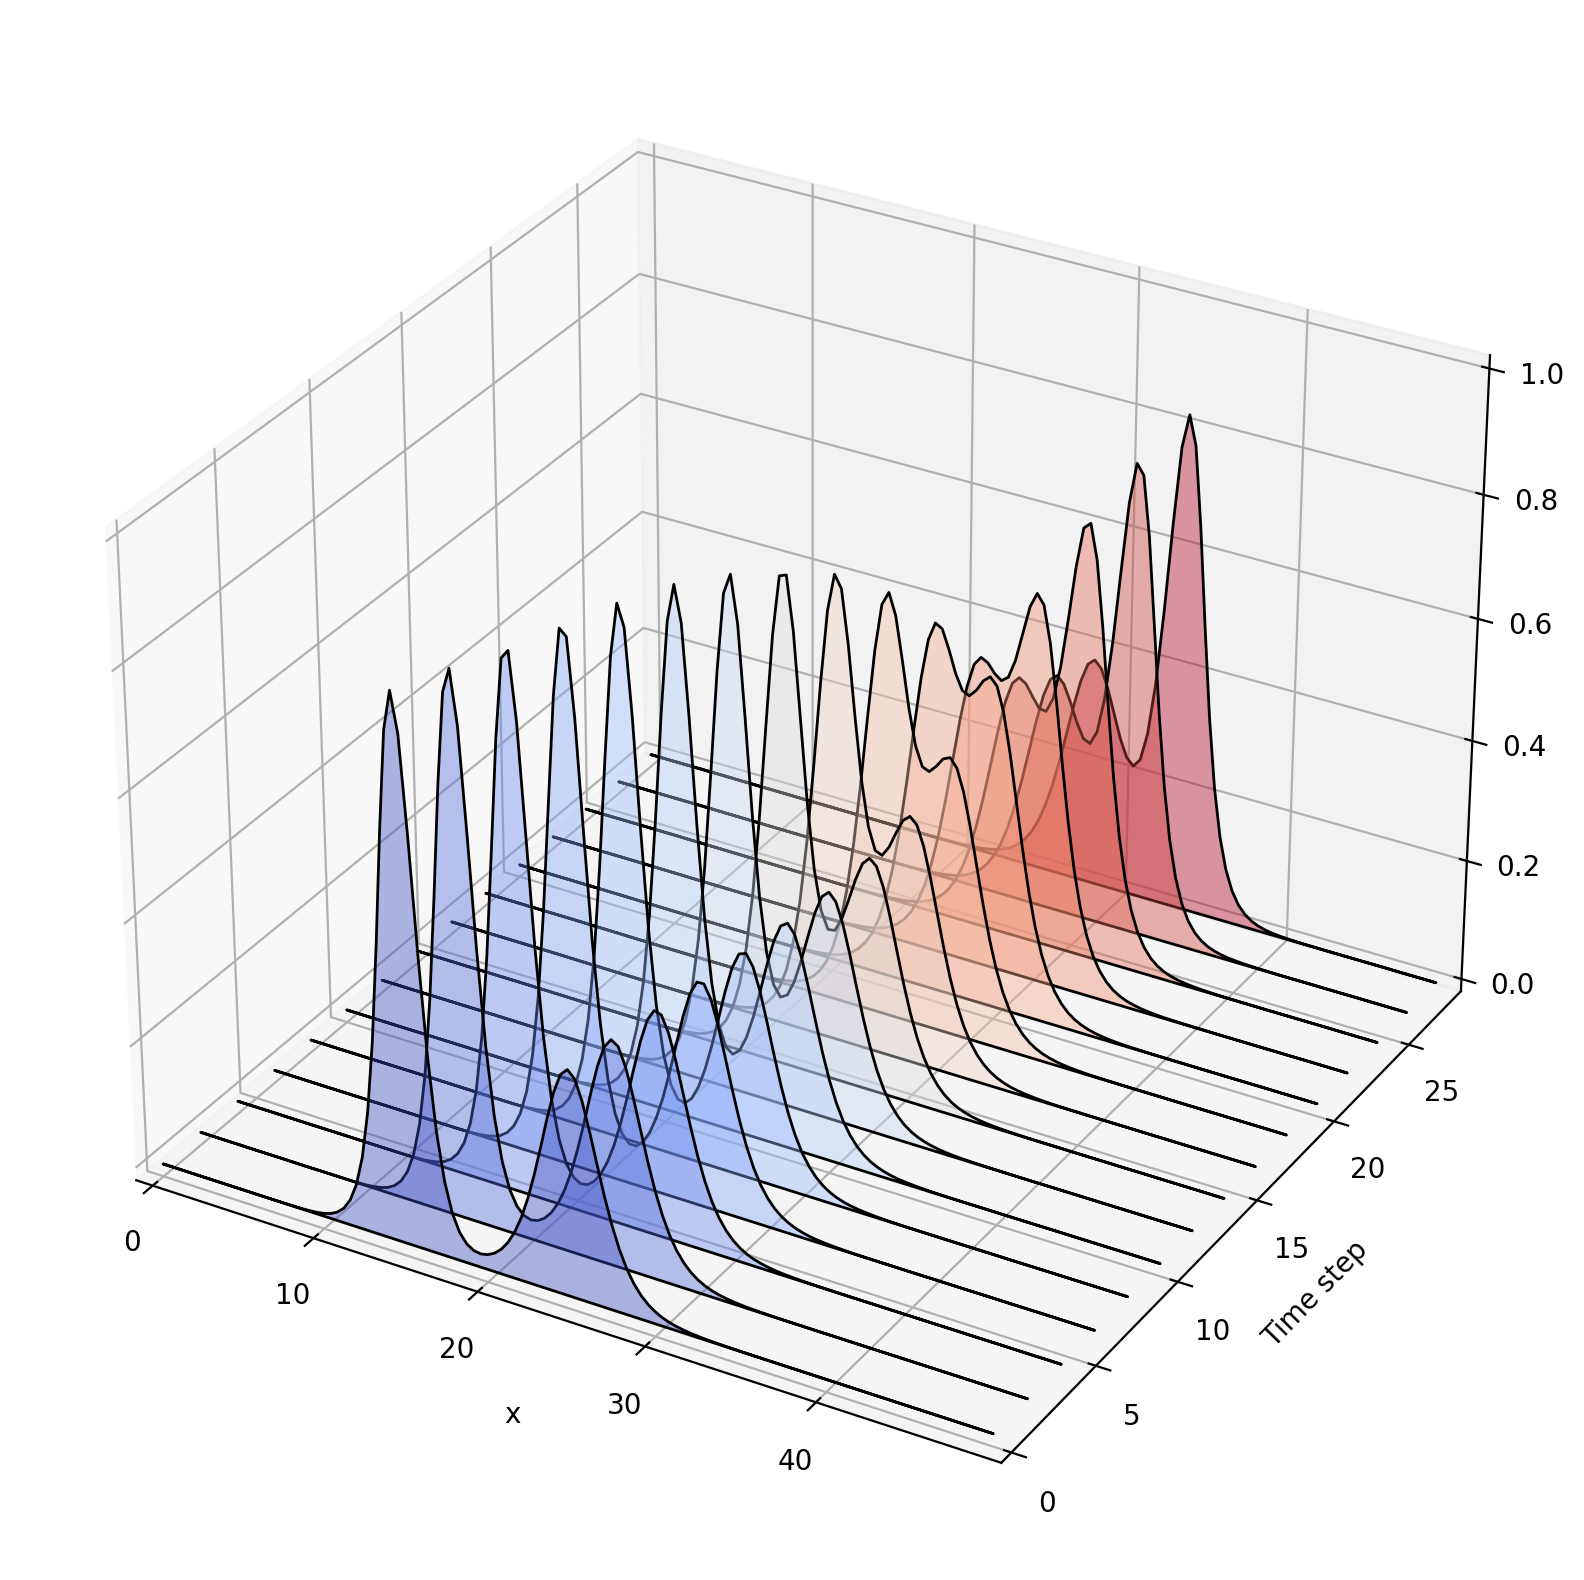

In [584]:
import numpy
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
from matplotlib.collections import PolyCollection

def drawPropagation(sample, dt_step=1):

    T = numpy.linspace(0, 50-50/120, 120)
    z = numpy.arange(sample.shape[0])[::dt_step]#numpy.linspace(0, 10, 10)
    sample = sample[::dt_step]
    sx = T.size
    sy = z.size

    T = numpy.tile(T, (sy, 1))
    z = numpy.tile(z, (sx, 1)).T

    fig = pyplot.figure(figsize=( 10,10), dpi=200)
    ax = fig.add_subplot(1,1,1, projection='3d')
    U = sample

    verts = []
    for i in range(T.shape[0]):
        verts.append(list(zip(T[i, :], U[i, :])))

    colors = pyplot.cm.coolwarm(numpy.linspace(0, 1, sy))

    # make the color transparent
    colors[:,3] = np.ones(sy) * 0.4 #numpy.linspace(0.1, 1, sy)

    poly = PolyCollection(verts, facecolors=colors, edgecolors=(0,0,0,1))
    ax.add_collection3d(poly, zs=z[:, 0], zdir='y')
    ax.set_xlim3d(numpy.min(T), numpy.max(T))
    ax.set_ylim3d(numpy.min(z), numpy.max(z))
    ax.set_zlim3d(0, 1)
    ax.set_xlabel('x')
    #ax.set_zlabel('Time step')
    ax.set_ylabel('Time step')
    #ax.view_init(30, 140)

drawPropagation(data[13], dt_step=2)
pyplot.show()

[ 0  3  6  9 12 15 18 21 24 27]


IndexError: index 9 is out of bounds for axis 0 with size 9

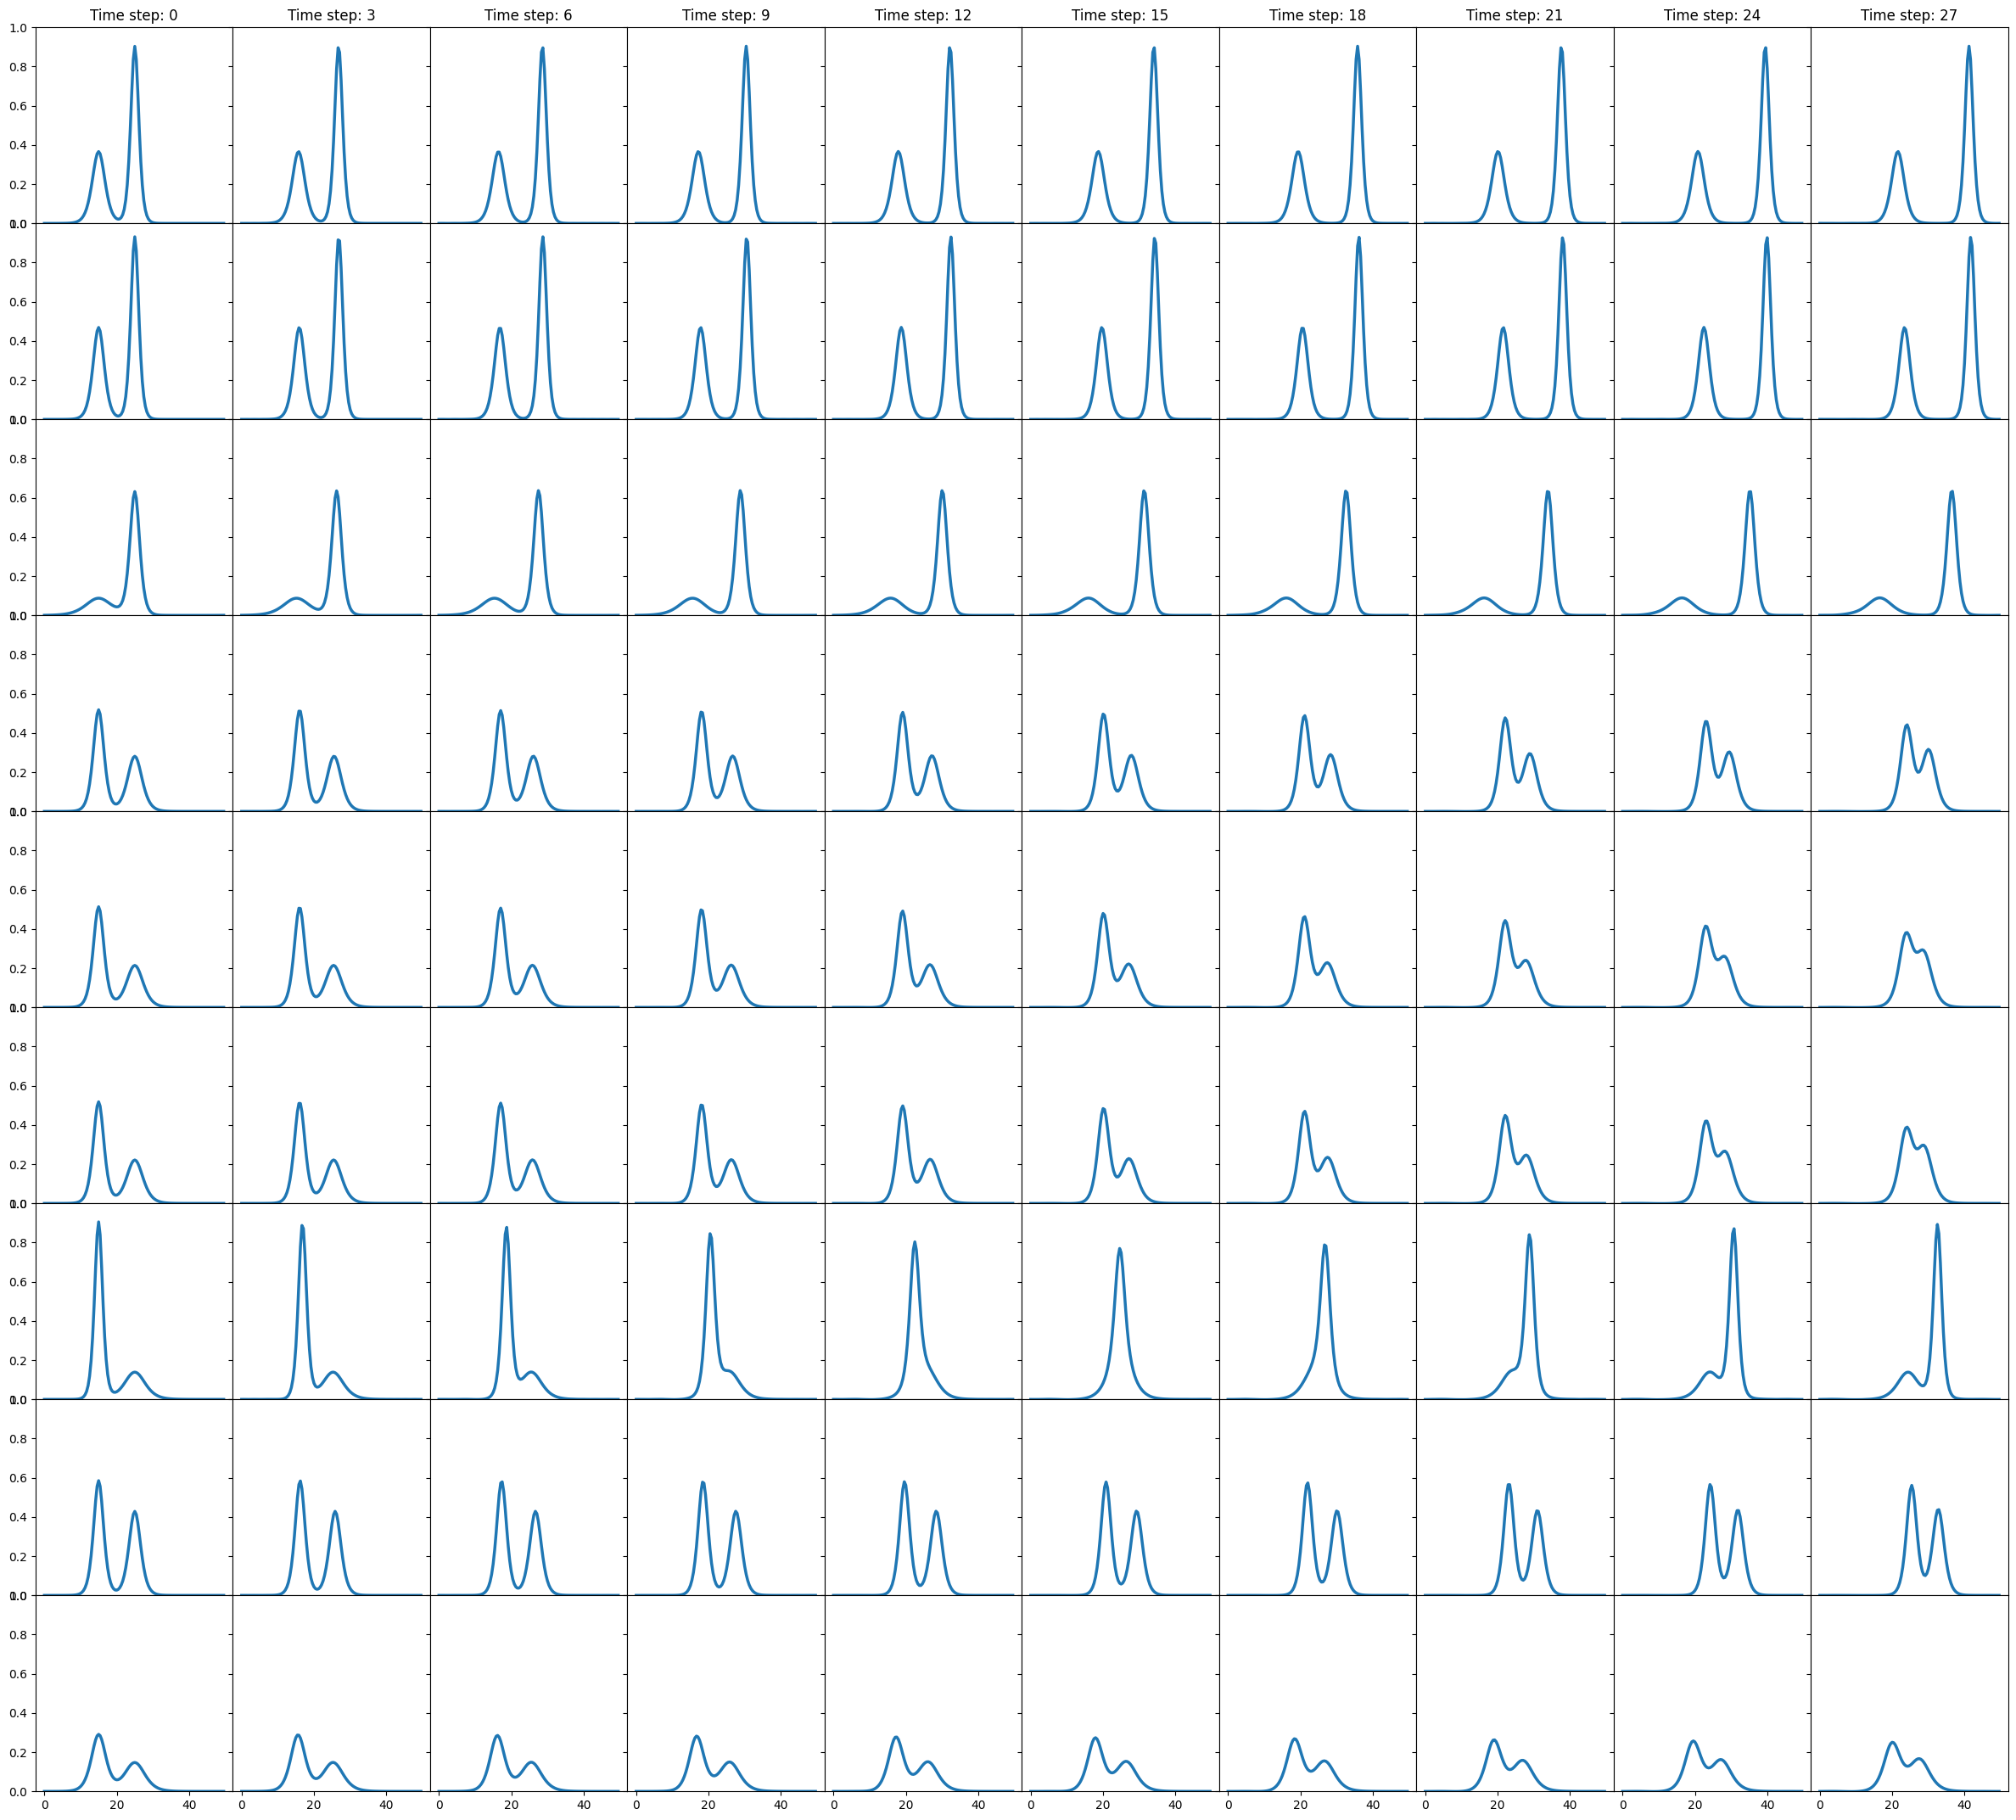

In [585]:
import matplotlib.pyplot as plt

def plot_waves(waves, dt_step=1, num_samples=2):
    """Plots the KdV solutions at different time steps in a grid."""

    num_waves, time_steps, x_dim = waves.shape
    dt_steps = np.arange(time_steps)[::dt_step]
    print(dt_steps)
    fig, axes = plt.subplots(num_samples, len(dt_steps), figsize=(3*len(dt_steps), 3*num_samples ) ,sharex=True, sharey=True, dpi=100)
    # set max y value
    # Set general title

    for i, wave in enumerate(waves):

        #axes[i, 0].set_ylabel("Amplitude")
        for j, t in enumerate(dt_steps):
            if i == 0:
                axes[0,j].set_title("Time step: {}".format(t))
                #axes[i,j].set_xlabel("x")
            axes[i,j].set_ylim(0, 1)
            axes[i,j].plot(np.linspace(0, 50 - 50/x_dim, x_dim), wave[t], linewidth=2.5)

            plt.subplots_adjust(hspace=0, wspace=0)
    plt.tight_layout()
    plt.show()
plot_waves(data[32:64], dt_step=3, num_samples=9)

2e-06

In [85]:
import numpy as np
M = 120
P = 50
eta = 6.0
gamma = 1.0

def grid(P, M):
    dx = P/M
    x = np.linspace(0, P-dx, M)
    return x, dx

x, dx = grid(P, M)
k1, k2 = 0.7, 0.5

d1 = .3 # Hard coded
d2 = .5 # Hard coded
sech = lambda a: 1/np.cosh(a) # sech isn't defined in NumPy
u0 = 0
u0 += (-6./-eta)*2 * k1**2 * sech(np.abs(k1 * ((x+P/2-P*d1) % P - P/2)))**2
u1 = (-6./-eta)*2 * k2**2 * sech(np.abs(k2 * ((x+P/2-P*d2) % P - P/2)))**2

In [86]:
u0.shape

(120,)

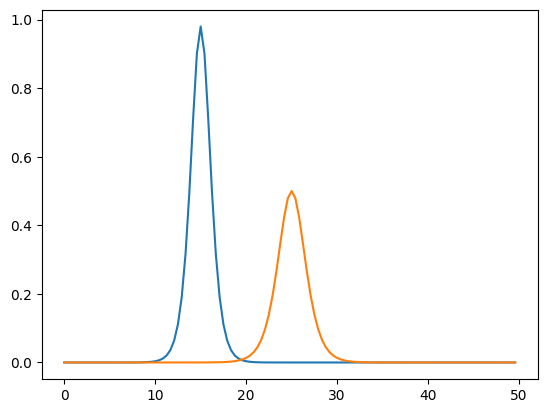

In [87]:
# improt matplotlbi
import matplotlib.pyplot as plt
# plot the solution
plt.plot(x, u0, label='u0')
plt.plot(x, u1, label='u1')

In [88]:
import scipy
def energy_conservation(u, dx, eta=6.0, gamma=1.0):
    """
    Returns the energy conservation error for the KdV equation
    u: solution tensor of shape (batch_size, time_steps, M)
    M: number of spatial points
    dx: spatial step size
    eta: model specific parameter
    gamma: model specific parameter
    :returns: energy conservation error tensor of shape (batch_size, time_steps) for each time step
    """
    M = u.size(-1)
    device = u.device
    e = np.ones(M)
    Dp = .5 / dx * scipy.sparse.spdiags([e, -e, e, -e], np.array([-M + 1, -1, 1, M - 1]), M, M).toarray()
    Dp = torch.tensor(Dp, dtype=torch.float32, device=device)

    H = lambda u: dx*torch.sum(-1/6*eta*u**3 + (.5*gamma**2*torch.matmul(Dp,u.transpose(1, 2)).transpose(1, 2)**2), dim=2)
    Ht = H(u)
    return Ht # torch.abs(Ht - Ht[:, 0, None])

def mass_conservation(u, dx):
    """
    Returns the mass conservation error for the KdV equation
    u: solution tensor of shape (batch_size, time_steps, M)
    M: number of spatial points
    dx: spatial step size
    :returns: mass conservation error tensor of shape (batch_size, time_steps) for each time step
    """
    H_mass = dx * torch.sum(u, dim=2)
    return H_mass #torch.abs(H_mass - H_mass[:, 0, None])

def momentum_conservation(u, dx):
    """
    Returns the momentum conservation error for the KdV equation
    u: solution tensor of shape (batch_size, time_steps, M)
    M: number of spatial points
    dx: spatial step size
    :returns: momentum conservation error tensor of shape (batch_size, time_steps) for each time step
    """
    H_mom = dx * torch.sum(u**2, dim=2)
    return H_mom # torch.abs(H_mom - H_mom[:, 0, None])

In [89]:
import torch
u0 = torch.tensor(u0, dtype=torch.float32).unflatten(0, (1, 1, -1))
u1 = torch.tensor(u1, dtype=torch.float32).unflatten(0, (1, 1, -1))
print(u0.size())

print(f"Mass init state u0: {mass_conservation(u0, dx)}, Mass init state u1: {mass_conservation(u1, dx)}" )
print(f"\tMass init state u0+u1: {mass_conservation(u0+u1, dx)}")

print(f"Momentum init state u0: {momentum_conservation(u0, dx)}, Momentum init state u1: {momentum_conservation(u1, dx)}" )
print(f"\tMomentum init state u0+u1: {momentum_conservation(u0+u1, dx)}")

print(f"Energy init state u0: {energy_conservation(u0, dx)}, Energy init state u1: {energy_conservation(u1, dx)}" )
print(f"\tEnergy init state u0+u1: {energy_conservation(u0+u1, dx)}")

torch.Size([1, 1, 120])
Mass init state u0: tensor([[2.8000]]), Mass init state u1: tensor([[2.0000]])
	Mass init state u0+u1: tensor([[4.8000]])
Momentum init state u0: tensor([[1.8293]]), Momentum init state u1: tensor([[0.6667]])
	Momentum init state u0+u1: tensor([[2.4974]])
Energy init state u0: tensor([[-1.1029]]), Energy init state u1: tensor([[-0.2027]])
	Energy init state u0+u1: tensor([[-1.3071]])


In [91]:
mass_conservation(u0, dx), momentum_conservation(u0, dx), energy_conservation(u0, dx)

(tensor([[2.8000]]), tensor([[1.8293]]), tensor([[-1.1029]]))